In [1]:
# 파이썬 성능개선법. 자료구조 효율적인 저장법
# (1) cython 정적컴파일 방법
# (2) IPython.parallel 클러스터나 로컬 컴퓨터에서 코드와 함수를 병렬 실행
# (3) numpexpr 수치 연산 속도 계선
# (4) multiprocessing 로컬 병렬 프로세싱을 위한 파이썬 표준 모델
# (5) Numba 단일 cpu 성능 개선을 위해 파이썬 코드를 동적으로 컴파일
# (6) NumbaPro 멀티 코어 CPU와 GPU의 성능 개선을 위해 파이썬 코드를 동적으로 컴파일

In [1]:
# 여러 함수의 성능을 비교하기 위한 함수
def perf_comp_data(func_list, data_list, rep=3, number=1):
    # func_list : 함수 이름 문자열 리스트
    # data_list : 자료 집합 문자열 리스트
    # rep       : 전체 비교를 위한 반복 횟수
    # number    : 개별 함수의 실행 횟수

    from timeit import repeat

    res_list={}

    # 특정 함수나 코드의 실행 시간 측정
    for name in enumerate(func_list):
        stmt = name[1] + '(' + data_list[name[0]] + ')'
        setup = "from __main__ import " + name[1] + ', ' + data_list[name[0]]
        # stmt : 실행 측정할 코드 및 함수
        # setup : stmt를 실행하기 위해 사전에 필요한 코드나 함수를 선언. setup의 실행 시간은 전체 측정 실행 시간에서 제외됨
        # number : 선언한 stmt의 수행 횟수. 선언하지 않으면 기본값으로 1000000번이 실행됨
        results = repeat(stmt=stmt, setup=setup, repeat=rep, number=number)
        res_list[name[1]] = sum(results) / rep
     
    res_sort = sorted(res_list.items(), key = lambda x : x[1])

    for item in res_sort:
        rel = item[1] / res_sort[0][1]

        print('function: ' + item[0] + ', av. time sec: %9.5f, ' %item[1] + 'relative: %6.1f' %rel)


In [3]:
from math import *
import numpy as np
import numexpr as ne

I=500000
a_py = range(I)
a_np = np.arange(I)

def f(x):
    return abs(cos(x))**0.5 + sin(2+3*x)

# 명시적으로 반복문을 사용한 표준 파이썬 함수
def f1(a):
    res=[]
    for x in a:
        res.append(f(x))
    return res

# 암묵적 반복문을 사용한 반복자 구현
def f2(a):
    return [f(x) for x in a]

# 암묵적 반복문과 eval명령을 사용한 반복자 구현
def f3(a):
    ex = 'abs(cos(x))**0.5 + sin(2+3*x)'
    return [eval(ex) for x in a]

# numpy 벡터화 구현
def f4(a):
    return (np.abs(np.cos(a))**0.5 + np.sin(2+3*a))

# numpexpr를 사용한 단일 스레드 구현
def f5(a):
    ex = 'abs(cos(a))**0.5 + sin(2+3*a)'
    ne.set_num_threads(1)
    return ne.evaluate(ex)

# numpexpr를 사용한 멀티 스레드 구현
def f6(a):
    ex = 'abs(cos(a))**0.5 + sin(2+3*a)'
    ne.set_num_threads(16)
    return ne.evaluate(ex) 

In [4]:
%%time
r1 = f1(a_py)
r2 = f2(a_py)
r3 = f3(a_py)
r4 = f4(a_np)
r5 = f5(a_np)
r6 = f6(a_np)


CPU times: user 6.56 s, sys: 189 ms, total: 6.75 s
Wall time: 6.79 s


In [5]:
 np.allclose(r1, r2)
 np.allclose(r1, r3)
 np.allclose(r1, r4)
 np.allclose(r1, r5)
 np.allclose(r1, r6)

True

In [6]:
func_list = ['f1', 'f2', 'f3', 'f4', 'f5', 'f6']
data_list = ['a_py', 'a_py', 'a_py', 'a_np', 'a_np', 'a_np']

perf_comp_data(func_list, data_list)

function: f6, av. time sec:   0.00389, relative:    1.0
function: f5, av. time sec:   0.01549, relative:    4.0
function: f4, av. time sec:   0.01913, relative:    4.9
function: f2, av. time sec:   0.21555, relative:   55.4
function: f1, av. time sec:   0.24459, relative:   62.8
function: f3, av. time sec:   6.38687, relative: 1640.5


In [7]:
# 메모리 배치와 성능
# numpy에서는 ndarray 객체마다 dtype을 설정할 수 있음.
# 또한 ndarray 객체를 초기화할 때 두 개의 다른 메모리 배치 방법을 선택할 수 있으며 객체의 구조에 따라 특정한 메모리 배치가 더 유리할 수 있음
import numpy as np
b = np.zeros((3,3), dtype=np.float64, order='C')

# 행 우선 저장방식
c = np.array([[1.,1.,1.],
              [2.,2.,2.],
              [3.,3.,3.]], order='C')

# 열 우선 저장방식
f = np.array([[1.,1.,1.],
              [2.,2.,2.],
              [3.,3.,3.]], order='F')

x = np.random.standard_normal((3, 1500000))
C = np.array(x, order='C')
F = np.array(x, order='F')

In [8]:
%timeit C.sum(axis=0)
%timeit C.sum(axis=1)
%timeit C.std(axis=0)
%timeit C.std(axis=1)

5.14 ms ± 19.4 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
1.87 ms ± 15.1 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
29.9 ms ± 302 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
13.4 ms ± 125 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [9]:
%timeit F.sum(axis=0)
%timeit F.sum(axis=1)
%timeit F.std(axis=0)
%timeit F.std(axis=1)

22.5 ms ± 95.6 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
23.3 ms ± 103 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
66.8 ms ± 95.2 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
63.1 ms ± 177 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [10]:
# 유러피언 옵션을 몬테카를로를 이용해서 구할 때 병렬 프로그래밍을 이용해 구해보자
import numpy as np
import scipy.stats as stat


# 몬테카를로 시뮬레이션 으로 구한 유러피언 옵션
def bsm_mcs_europian_option(S, K, T, r, sigma, option_type):

    # 만기 주가는 다음과 같은 식을 따름. 유도는 13장 참고 
    # ST = S * np.exp((r-0.5 * sigma ** 2)*T + sigma * np.sqrt(T) * z)
    
    S0 = S
    I = 20000                                  # 시뮬레이션 횟수
    M = 50                                    # 만기까지 기간을 M 구간 나눔
    dt = T/M

    np.random.seed(0)                         # 난수 초기값 설정
    z = np.random.standard_normal((M+1,I))    # 난수 생성 (M+1 by I)

    S = np.zeros((M+1,I))
    S[0] = S0                                 # [S0, ... S0] 리스트 안의 원소수 I개

    for t in range(1, M+1):
        S[t] = S[t-1] * np.exp((r-0.5 * sigma ** 2)*dt + sigma * np.sqrt(dt) * z[t])

    # 즉 S는 M구간의 주가이동경로를 I개 만큼 가지고 있음. 주가이동경로는 기하브라운운동(gbm))
    # 마지막 구간 즉 만기에서 나온 값들을 평균냄 (몬테카를로 시뮬레이션)
    # 여기서 주의해야할 점은 np.max와 np.maximum이 다르다는 것. 
    # np.max는 전체 배열에서 최대 요소 값을 찾음. np.maximum은 요소 별 최댓값을 찾음
    if option_type == 'call':
        hT = np.maximum(S[-1] - K, 0)

        return np.exp(-r * T) * np.sum(hT) / I

    else:
        hT = np.maximum(K - S[-1], 0)

        return np.exp(-r * T) * np.sum(hT) / I

# 블랙-숄즈-머튼 모형의 유러피언 옵션과 비교
def europian_option(S, K, T, r, sigma, option_type):
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    # d2 = (np.log(S / K) + (r - 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))

    if option_type == 'call':
        V = S * stat.norm.cdf(d1) - K * np.exp(-r * T) * stat.norm.cdf(d2)

    else:
        V = K * np.exp(-r * T) * stat.norm.cdf(-d2) - S * stat.norm.cdf(-d1)

    return V

print(europian_option(100,105,1,0.05,0.2,'call'))
print(europian_option(100,105,1,0.05,0.2,'put'))

print(bsm_mcs_europian_option(100,105,1,0.05,0.2,'call'))
print(bsm_mcs_europian_option(100,105,1,0.05,0.2,'put'))

8.021352235143176
7.9004418077181455
8.099034277924247
7.7963866473350585


In [11]:
# 벤치마크 케이스로 행사가(strike price)가 다른 100개의 옵션을 평가해보자
# 함수 seq_value는 몬테카를로 계산기를 순차적으로 사용하여 행사가와 평가 결과를 리스트 객체에 담아 반환한다.

# 옵션 가치의 순차 계산
def seq_value(n):
    # n은 행사가의 갯수

    strikes = np.linspace(80,120,n)
    option_values = []

    for strike in strikes:
        option_values.append(bsm_mcs_europian_option(100,strike,1,0.05,0.2,'call'))
    
    return strikes, option_values

n=100
%time strikes, option_values_seq = seq_value(n)


CPU times: user 3.43 s, sys: 167 ms, total: 3.59 s
Wall time: 3.62 s


Text(0, 0.5, 'European call option values')

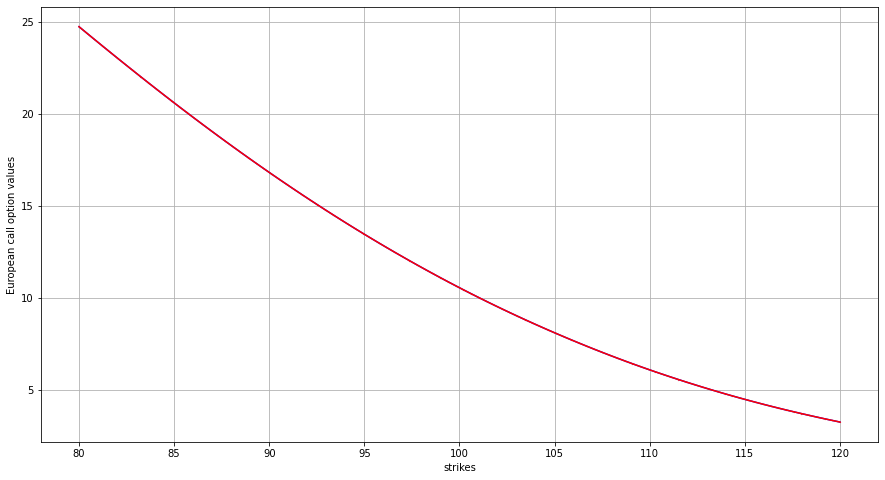

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(15,8))
plt.plot(strikes, option_values_seq, color='b')
plt.plot(strikes, option_values_seq, color='r', markersize=0.5, marker='.')
plt.grid(True)
plt.xlabel('strikes')
plt.ylabel('European call option values')

In [14]:
# 병렬계산 방식 (2) IPython.parallel 클러스터나 로컬 컴퓨터에서 코드와 함수를 병렬 실행
# 참고 : https://velog.io/@prayme/Ipyparallel-%EB%AC%B8%EC%84%9C-%EC%9D%BD%EA%B8%B0
# https://coderzcolumn.com/tutorials/python/ipyparallel-parallel-processing-in-python#3.2
# https://github.com/ipython/ipyparallel
# async의 개념도 공부..
# 현재 작동 안함 ...
# terminal에 ipcluster start로 시작
# ipcluster stop으로 정지


import ipyparallel as ipp
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

rc = ipp.Client(profile="default")
print(rc.ids)
# direct_view = rc[:]
# dv = rc[:]
# direct_view.apply
view = rc.load_balanced_view()


# @ipp.require('np')
# 몬테카를로 시뮬레이션 으로 구한 유러피언 옵션
def bsm_mcs_europian_option(S, K, T, r, sigma, option_type):

    # 만기 주가는 다음과 같은 식을 따름. 유도는 13장 참고 
    # ST = S * np.exp((r-0.5 * sigma ** 2)*T + sigma * np.sqrt(T) * z)
    
    import numpy as np

    S0 = S
    I = 20000                                  # 시뮬레이션 횟수
    M = 50                                    # 만기까지 기간을 M 구간 나눔
    dt = T/M

    np.random.seed(0)                         # 난수 초기값 설정
    z = np.random.standard_normal((M+1,I))    # 난수 생성 (M+1 by I)

    S = np.zeros((M+1,I))
    S[0] = S0                                 # [S0, ... S0] 리스트 안의 원소수 I개
    
    for t in range(1, M+1):
        S[t] = S[t-1] * np.exp((r-0.5 * sigma ** 2)*dt + sigma * np.sqrt(dt) * z[t])

    # 즉 S는 M구간의 주가이동경로를 I개 만큼 가지고 있음
    # 마지막 구간 즉 만기에서 나온 값들을 평균냄
    # 여기서 주의해야할 점은 np.max와 np.maximum이 다르다는 것. 
    # np.max는 전체 배열에서 최대 요소 값을 찾음. np.maximum은 요소 별 최댓값을 찾음
    if option_type == 'call':
        hT = np.maximum(S[-1] - K, 0)

        return np.exp(-r * T) * np.sum(hT) / I

    else:
        hT = np.maximum(K - S[-1], 0)

        return np.exp(-r * T) * np.sum(hT) / I

# 옵션 가치의 병렬 계산
def par_value(n):
    # n은 행사가의 갯수

    strikes = np.linspace(80,120,n)
    option_values = []
    all_ids = []

    for strike in strikes:
        # print(strike)
        # apply_async와 apply_sync의 차이... 
        value = view.apply_async(bsm_mcs_europian_option,100,strike,1,0.05,0.2,'call')
        option_values.append(value)
    rc.wait(option_values)
    return strikes, option_values

n=100
%time strikes, option_values_par = par_value(n)
print(option_values_par[0].metadata)
print('check2')
# result = [x.get_dict() for x in option_values_par]
# print(result)
print('check3')
plt.figure(figsize=(15,8))
plt.plot(strikes, option_values_par, color='b')
plt.plot(strikes, option_values_par, color='r', markersize=0.5, marker='.')
plt.grid(True)
plt.xlabel('strikes')
plt.ylabel('European call option values')
print('check4')


Waiting for connection file: ~/.ipython/profile_default/security/ipcontroller-client.json


OSError: Connection file '~/.ipython/profile_default/security/ipcontroller-client.json' not found.
You have attempted to connect to an IPython Cluster but no Controller could be found.
Please double-check your configuration and ensure that a cluster is running.

In [21]:
# 멜티프로세싱 테스트. 파이썬의 표준 멀티프로세싱 모듈 사용
# 하나의 컴퓨터에서 코드를 병렬실행. 

import multiprocessing as mp
import matplotlib.pyplot as plt
import numpy as np
from time import time

def simulate_geometric_brownian_motion(p):
    M, I = p
      # time steps, paths
    S0 = 100; r = 0.05; sigma = 0.2; T = 1.0
      # model parameters
    dt = T / M
    paths = np.zeros((M + 1, I))
    paths[0] = S0
    for t in range(1, M + 1):
        paths[t] = paths[t - 1] * np.exp((r - 0.5 * sigma ** 2) * dt +
                    sigma * np.sqrt(dt) * np.random.standard_normal(I))
    return paths

paths = simulate_geometric_brownian_motion((5, 2))
print(paths)


I = 10000  # number of paths
M = 50  # number of time steps
t = 20  # number of tasks/simulations

pool = mp.Pool(processes=4)


[[100.         100.        ]
 [112.05633581  94.15514269]
 [109.58461751 114.46685697]
 [122.73759783 127.76507413]
 [128.88727591 133.96302932]
 [115.26907786 133.01981557]]


In [25]:
%time pool.map(simulate_geometric_brownian_motion, t * [(M, I),])


CPU times: user 70.5 ms, sys: 134 ms, total: 204 ms
Wall time: 283 ms


[array([[100.        , 100.        , 100.        , ..., 100.        ,
         100.        , 100.        ],
        [ 98.85926478,  99.38233661,  96.99598864, ...,  98.10644333,
         101.37387396, 101.01748029],
        [102.87400808, 100.64279732,  94.68167216, ...,  94.88117985,
         103.5378687 ,  98.32803599],
        ...,
        [104.71387974, 121.21214539,  85.19673872, ..., 159.59722062,
          87.67145707,  77.53429112],
        [108.90616126, 121.83944285,  84.91480232, ..., 159.55095653,
          87.11954006,  81.23374195],
        [111.69684821, 117.38879919,  83.06726167, ..., 163.20125161,
          86.08191911,  80.96648877]]),
 array([[100.        , 100.        , 100.        , ..., 100.        ,
         100.        , 100.        ],
        [ 96.12782876,  96.31816337,  99.07638955, ...,  99.07867518,
          98.83416565,  99.27566675],
        [ 97.87929795,  95.07363825,  98.66625298, ...,  93.42223804,
         104.19256702, 101.59421047],
        ...,


In [23]:
times = []
for w in range(1, 5):
    t0 = time()
    pool = mp.Pool(processes=w)
      # the pool of workers
    result = pool.map(simulate_geometric_brownian_motion, t * [(M, I), ])
      # the mapping of the function to the list of parameter tuples
    times.append(time() - t0)

Text(0.5, 1.0, '20 Monte Carlo simulations')

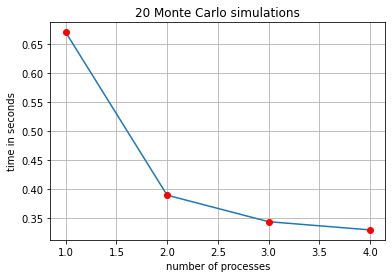

In [24]:
plt.plot(range(1, 5), times)
plt.plot(range(1, 5), times, 'ro')
plt.grid(True)
plt.xlabel('number of processes')
plt.ylabel('time in seconds')
plt.title('%d Monte Carlo simulations' % t)
# tag: multi_proc
# title: Comparison execution speed dependent on the number of threads used (4 core machine)
# size: 60

In [28]:
# 동적 컴파일 numba
# 오류 관련 : https://github.com/numba/numba/issues/5600
from math import cos, log
import numba as nb

def f_py(I,J):
    res=0

    for i in range(I):
        for j in range(J):
            res += int(cos(log(1)))
    return res
I, J = 5000, 5000

In [29]:
%time f_py(I, J)

CPU times: user 6.59 s, sys: 56.8 ms, total: 6.64 s
Wall time: 6.69 s


25000000

In [31]:
f_nb = nb.jit(f_py)


In [32]:
%time f_nb(I, J)


CPU times: user 216 ms, sys: 35.4 ms, total: 251 ms
Wall time: 504 ms


25000000

In [33]:
def f_np(I, J):
    a = np.ones((I, J), dtype=np.float64)
    return int(np.sum(np.cos(np.log(a)))), a

In [34]:
%time res, a = f_np(I, J)


CPU times: user 407 ms, sys: 225 ms, total: 631 ms
Wall time: 697 ms


In [35]:
func_list = ['f_py', 'f_np', 'f_nb']
data_list = 3 * ['I, J']

perf_comp_data(func_list, data_list)


function: f_nb, av. time sec:   0.00000, relative:    1.0
function: f_np, av. time sec:   0.58481, relative: 120050.8
function: f_py, av. time sec:   6.60774, relative: 1356453.9


In [38]:
# model & option Parameters
S0 = 100.  # initial index level
T = 1.  # call option maturity
r = 0.05  # constant short rate
vola = 0.20  # constant volatility factor of diffusion

# time parameters
M = 1000  # time steps
dt = T / M  # length of time interval
df = exp(-r * dt)  # discount factor per time interval

# binomial parameters
u = exp(vola * sqrt(dt))  # up-movement
d = 1 / u  # down-movement
q = (exp(r * dt) - d) / (u - d)  # martingale probability

def binomial_np(strike):
    ''' Binomial option pricing with NumPy.
    
    Parameters
    ==========
    strike : float
        strike price of the European call option
    '''
    # Index Levels with NumPy
    mu = np.arange(M + 1)
    mu = np.resize(mu, (M + 1, M + 1))
    md = np.transpose(mu)
    mu = u ** (mu - md)
    md = d ** md
    S = S0 * mu * md
    
    # Valuation Loop
    pv = np.maximum(S - strike, 0)

    z = 0
    for t in range(M - 1, -1, -1):  # backwards iteration
        pv[0:M - z, t] = (q * pv[0:M - z, t + 1]
                        + (1 - q) * pv[1:M - z + 1, t + 1]) * df
        z += 1
    return pv[0, 0]

In [39]:
M = 1000  # reset number of time steps
%time round(binomial_np(100), 3)

CPU times: user 64.6 ms, sys: 16 ms, total: 80.5 ms
Wall time: 80.3 ms


10.449

In [40]:
def binomial_py(strike):
    ''' Binomial option pricing via looping.
    
    Parameters
    ==========
    strike : float
        strike price of the European call option
    '''
    # LOOP 1 - Index Levels
    S = np.zeros((M + 1, M + 1), dtype=np.float64)
      # index level array
    S[0, 0] = S0
    z1 = 0
    for j in range(1, M + 1, 1):
        z1 = z1 + 1
        for i in range(z1 + 1):
            S[i, j] = S[0, 0] * (u ** j) * (d ** (i * 2))
            
    # LOOP 2 - Inner Values
    iv = np.zeros((M + 1, M + 1), dtype=np.float64)
      # inner value array
    z2 = 0
    for j in range(0, M + 1, 1):
        for i in range(z2 + 1):
            iv[i, j] = max(S[i, j] - strike, 0)
        z2 = z2 + 1
        
    # LOOP 3 - Valuation
    pv = np.zeros((M + 1, M + 1), dtype=np.float64)
      # present value array
    pv[:, M] = iv[:, M]  # initialize last time point
    z3 = M + 1
    for j in range(M - 1, -1, -1):
        z3 = z3 - 1
        for i in range(z3):
            pv[i, j] = (q * pv[i, j + 1] +
                        (1 - q) * pv[i + 1, j + 1]) * df
    return pv[0, 0]

In [41]:
%time round(binomial_py(100), 3)


CPU times: user 1.42 s, sys: 17.1 ms, total: 1.44 s
Wall time: 1.45 s


10.449

In [42]:
binomial_nb = nb.jit(binomial_py)


In [43]:
%time round(binomial_nb(100), 3)


CPU times: user 587 ms, sys: 42.7 ms, total: 630 ms
Wall time: 637 ms


10.449

In [44]:
func_list = ['binomial_py', 'binomial_np', 'binomial_nb']
K = 100.
data_list = 3 * ['K']

perf_comp_data(func_list, data_list)


function: binomial_np, av. time sec:   0.06153, relative:    1.0
function: binomial_nb, av. time sec:   0.16854, relative:    2.7
function: binomial_py, av. time sec:   1.32218, relative:   21.5


In [ ]:
# 이외 Cython이나 CUDA를 사용하는 방법도 있음